In [1]:
using Turing, Distributions, Random, MCMCChains, Plots, StatsPlots, Measures, BSON
# Set a random seed for reproducibility
Random.seed!(1234)

TaskLocalRNG()

In [2]:
#Load posteriror samples
BSON.@load "Posterior_Samples/level2_mixed.bson" all_posteriors_mixed
BSON.@load "Posterior_Samples/level2_uniform.bson" all_posteriors_uniform

In [5]:
#Sample vectors
#Mixed group data
sample_vectors_mixed = [
    [0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],  
    [0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1],  
    [0, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2], 
    [0, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2],  
    [0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2], 
    [0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2], 
    [0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2],  
    [0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2],  
    [0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1], 
    [0, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2],  
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
]
#Uniform group data
sample_vectors_uniform = [
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],  
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],  
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]  #Test
]


11-element Vector{Vector{Int64}}:
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [49]:
# Function to extract theta, alpha, and beta samples and store them in a single dictionary
function extract_posterior_samples(all_posteriors, sample_vectors, test, start_sample)
    
    n_samples = sum([length(s) for s in sample_vectors])
    n_containers = length(sample_vectors)
    
    current_container = Int[]  # Initialize an empty array to hold the container indices
    current_sample = Int[]     # Initialize an empty array to hold the sample indices

    # Iterate through each container and its samples
    for (container_index, samples) in enumerate(sample_vectors)
        # Append the container index for each sample in the container
        append!(current_container, [container_index for _ in samples])

        # Append the sample index for each sample in the container
        append!(current_sample, [i-1 for i in 1:length(samples)])
    end

    test1 = copy(current_container)
    test2 = copy(current_container)

    #This replaces the last container (test1) with the last container + 1 (test2)
    test2 = append!(test2[1:end-length(sample_vectors[end])], fill(current_container[end]+1, length(sample_vectors[end])))

    if test == "test1"
        current_container = test1
    elseif test == "test2"
        current_container = test2
    end
    
    # Create a single dictionary to store all posterior samples
    posterior_samples = Dict{String, Vector{Float64}}()

    # Identify the range for the last container's samples
    #start_last_container = length(current_sample) - length(sample_vectors[end]) + 1

    # Loop through the relevant posterior samples
    for i in start_sample:length(current_sample)
        container_index = current_container[i]
        sample_index = current_sample[i]

        # Extract the theta, alpha, and beta samples from the posterior
        theta_samples = vec(all_posteriors[i]["theta[$container_index][2]"])
        alpha_samples = vec(all_posteriors[i]["alpha"])
        beta_samples = vec(all_posteriors[i]["beta[2]"])  # Assuming beta[2] corresponds to the second value

        # Create unique keys for theta, alpha, and beta samples
        theta_key = "theta_container_$(container_index)_sample_$(sample_index)"
        alpha_key = "alpha_container_$(container_index)_sample_$(sample_index)"
        beta_key = "beta_container_$(container_index)_sample_$(sample_index)"

        # Store the samples in the dictionary with their respective keys
        posterior_samples[theta_key] = theta_samples
        posterior_samples[alpha_key] = alpha_samples
        posterior_samples[beta_key] = beta_samples
    end

    return posterior_samples
end

# Extract posterior samples
posterior_samples_test1_mixed = extract_posterior_samples(all_posteriors_mixed, sample_vectors_mixed, "test1", 1)
posterior_samples_test2_mixed = extract_posterior_samples(all_posteriors_mixed, sample_vectors_mixed, "test2", 1)
posterior_samples_test1_uniform = extract_posterior_samples(all_posteriors_uniform, sample_vectors_uniform, "test1", 1)
posterior_samples_test2_uniform = extract_posterior_samples(all_posteriors_uniform, sample_vectors_uniform, "test2", 1)


# Access and print the samples using the combined dictionary
#println("Theta samples for container_11_sample_1:")
println(posterior_samples_test2_mixed["alpha_container_12_sample_1"])

[2.9357919096483402, 2.5717178842985655, 4.127715684969497, 2.043325433653393, 3.431451484787961, 2.164624382286545, 2.4140976315349314, 3.0521353136667435, 3.952965909695313, 1.397708385853748, 1.4618376103343713, 1.2552132239494724, 1.031131609597839, 1.1013993312041488, 2.3587814472182504, 2.523398000466392, 3.4669866062237134, 3.225983155380471, 3.8794787476117403, 2.433390357974716, 2.4083727061873854, 1.3174367553116622, 3.348864354778809, 2.9197557315465446, 4.715691768445232, 1.6804768379804627, 6.164715805001153, 4.759273390849088, 1.7465921787171974, 2.164179431262783, 3.0937936178073495, 1.7055662144869292, 3.8383025836304085, 2.0623904757975735, 1.3341858097488073, 2.4969772116193627, 3.279994288526345, 1.2174085390670553, 1.4967531240193575, 1.2491210953736696, 2.8555861887757934, 4.999916898738331, 1.2988082576255697, 4.263218536491509, 2.126789166741204, 2.452186486407463, 2.0745975987742598, 2.1464825191058474, 3.5805191245575245, 3.1349194329768126, 2.3595067803054275,

[ Info: Saved animation to /Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/theta_evolution_test.gif


Plots.AnimatedGif("/Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/theta_evolution_test.gif")
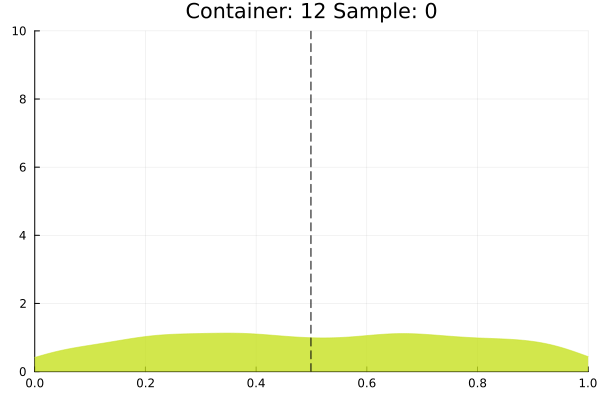

In [67]:
# Function to animate the evolution of theta posteriors for the last container in each iteration
function animate_theta_evolution_test(posterior_samples, container, samples)
    # Define a color palette for the containers
    container_colors = palette(:viridis, container+1)

    # Create an animation object
    anim = @animate for i in 0:samples

        theta_samples = posterior_samples["theta_container_$(container)_sample_$(i)"]

        
        # Calculate medians
        theta_median = median(theta_samples)
        #alpha_median = median(alpha_samples)
        #beta_median = median(beta_samples)

        # Get the color for the current container
        fill_color = container_colors[container]

        # Plot the density for the last container's theta and fill the area under the curve
        p = plot(xlims = (0, 1), ylims = (0, 10), legend = false,
                 title = "Container: $(container) Sample: $(i)")
        density!(theta_samples, fill = true, fillalpha = 0.8, alpha = 0.5, color = fill_color)

        # Show the median line for theta
        vline!([theta_median], color = :black, linestyle = :dash, linewidth = 1)
        
        # Annotate with the median values of theta, alpha, and beta
        #annotate!(0.75, 9, text("α: $(round(alpha_median, digits=2))", 8))
        #annotate!(0.75, 8, text("β[high value]: $(round(beta_median, digits=2))", 8))
        #annotate!(0.75, 7, text("θ[high value]: $(round(theta_median, digits=2))", 8))
    end

    # Display the animation
    gif(anim, "theta_evolution_test.gif", fps = 2)
end

# Example usage
animate_theta_evolution_test(posterior_samples_test2_mixed, 12, 30)